# Understanding RTP


Before we look at a packet, let's try to understand what we'd want to send to someone in order to use real-time commmunication.

## Understanding sound 
So, a 'speaker' takes some interval of 'sound' coming from our mouth, and converts that into 0's and 1's, and sends that overthe internet via IP protocol.

But what is sound, and how is it stored/measured, and then replayed, by speakers/mics?

Well, sound is a wave, which has two properties:
- Frequency (pitch)
- Amplitude (strength of sound)

A wave is a disturbance in the air molecules that travels (think of each bumping into its neighbor like a chain-reaction, or pressure-change), and our vocal chords have the ability to generate small pulses that we hear as 'frequency', at a strength we call amplitude.

So, we need to basically encode both of these peices of information in bits, and send this over to another device. Encoding frequency is easy, as if we sample consitently, this will be encoded in just recording it. So we really just need to measure amplitude over time.


## Encoding and playing sound

So, for audio encoding we have two questions to answer:
- How much precision in measuring wave-amplitude (bytes)
- How many times to measure per second
- Encoding???

Typical speakers will have 44,100 samples/sec, and 2bytes/sample to represent how a speaker should pull air in/out.


[This](https://www.youtube.com/watch?v=n2FKsPt83_A&t=940s) is a good simple intro to audio storing, using some easy python libraries that allow for abstraction, but still understanding.

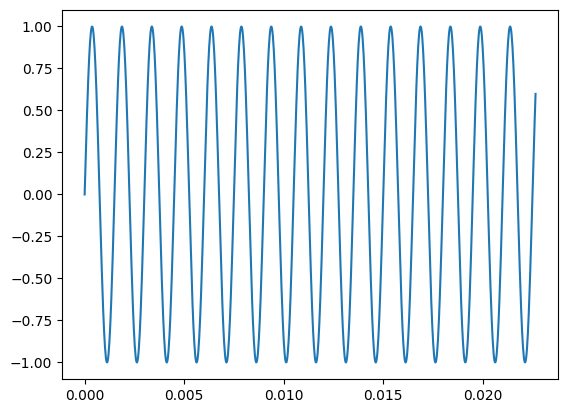

In [9]:
'''Visualizing Audio!

Let's create a sin-wav, and play
it on the speakers as a wav file.
'''

import matplotlib.pyplot as plt
import numpy as np
import wave

FREQ = 44100
DURATION = 3
PERIODS = 2000
FRAMES = FREQ*DURATION

x = np.linspace(0,DURATION,FRAMES)
y = np.sin(np.pi*2*(PERIODS/DURATION)*x)


# getting raw-bytes from the sin values...
# 16-bit -32,768 to 32,767
raw_hex = (y*32767).astype(np.int16) # 2 bytes
raw_hex = raw_hex.tobytes()


new_obj = wave.open("audio/sinwaveplay.wav",'wb')
new_obj.setnchannels(1)
new_obj.setsampwidth(2)
new_obj.setframerate(FREQ)
new_obj.setnframes(FRAMES)

new_obj.writeframes(raw_hex)


plt.plot(x[:1000],y[:1000])
plt.show()


Now, listening to it, we here a low-pitched sound, that goes up when we crank-up the frequency!

Let's use pyaudio to take info from the mic, and play this now.

In [1]:
import pyaudio
p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i))

p.terminate()

{'index': 0, 'structVersion': 2, 'name': 'J51 Yellow', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.014, 'defaultLowOutputLatency': 0.01, 'defaultHighInputLatency': 0.042, 'defaultHighOutputLatency': 0.1, 'defaultSampleRate': 16000.0}
{'index': 1, 'structVersion': 2, 'name': 'J51 Yellow', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.15074829931972789, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.16090702947845806, 'defaultSampleRate': 44100.0}
{'index': 2, 'structVersion': 2, 'name': 'MacBook Air Microphone', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.052675736961451246, 'defaultLowOutputLatency': 0.01, 'defaultHighInputLatency': 0.06283446712018141, 'defaultHighOutputLatency': 0.1, 'defaultSampleRate': 44100.0}
{'index': 3, 'structVersion': 2, 'name': 'MacBook Air Speakers', 'hostApi': 0, 'maxInputChanne

In [2]:
import wave
import time

# using pyaudio to record microphone easily
# Frames per buffer: how much to buffer mic
# Format: byte-width per

FRAMES_PER_BUFFER = 1000
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000

SECONDS = 5

p = pyaudio.PyAudio()
stream = p.open(
    format = FORMAT,
    input_device_index=0,input=True,
    channels=CHANNELS,
    rate=RATE,
    frames_per_buffer=FRAMES_PER_BUFFER
)

frames = []
for i in range(int((RATE/FRAMES_PER_BUFFER)*SECONDS)):
    data = stream.read(FRAMES_PER_BUFFER)
    frames.append(data) # stream of data


stream.stop_stream()
stream.close()
p.terminate()


# joining list of frames...
frames = b"".join(frames)

In [3]:
new_obj = wave.open("pyaudio_test.wav",'wb')

with wave.open('test_record.wav','wb') as wf:
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(2)
    wf.setframerate(RATE)
    wf.setnframes(RATE*SECONDS)

    wf.writeframes(frames)


Ok, now let's code something simple to send the audio over LAN!

The idea is we can just use pyaudio to also write.

In [ ]:
import socket
import threading
import pyaudio
import soxr # converting channels
import time
import numpy as np
import queue

class Communicator:
    ##################################
    @staticmethod
    def convert_channels(c_in,c_out,np_array):
        if c_in == c_out:
            return np_array
        else:
            if c_in == 2 and c_out == 1:
                n = len(np_array)
                data = np.reshape(np_array,[n//4,2,2])
                return data.mean(1) # get right axis!
            
            elif c_out == 2 and c_in == 1:
                # mono to stereo
                # N, --> (N,2), then formatted byte-wise!
                return np.stack([np_array,np_array],axis=-1)
            else: 
                # dont handle more for now
                raise NameError("to many stuff!")
    ##################################

    def __init__(self,send_port,recv_port,ip,dest_ip,in_params,out_params,seconds=5):
        self.in_params = in_params
        self.out_params = out_params
        self.send_port = send_port
        self.recv_port = recv_port
        self.dest_ip = dest_ip
        self.seconds= seconds
        self.stop_event = threading.Event()
        self.ip = ip
        self.recv_params = None

        self.q = queue.Queue()
        self.q_frames = queue.Queue()

        # sock init
        self.sock_send = socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
        ###################

        self.p = pyaudio.PyAudio()

        # audio stream initiate
        self.input_stream = self.p.open(
            input_device_index=in_params["index"],
            input=True,output=False,
            rate=in_params["rate"],
            channels=in_params["channels"],
            frames_per_buffer = in_params["chunk"],
            format=pyaudio.paInt16
            )
        self.output_stream = self.p.open(
            input_device_index=out_params["index"],
            output=True,input=False,
            rate=out_params["rate"],
            channels=out_params["channels"],
            frames_per_buffer = out_params["chunk"],
            format=pyaudio.paInt16
            )
        
    # recving audio constantly
    def recv_packets(self,buffer=1024):
        sock_recv = socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
        sock_recv.bind((self.ip,self.recv_port))

        while not self.stop_event.is_set():
            self.q.put(sock_recv.recvfrom(buffer))
            print("*RECEIVED MESSAGE!")
        
        sock_recv.close()
        print("Recving Stopped")

    # for sending audio queue
    def send_packets(self):
        while not self.stop_event.is_set:
            data = self.q_frames.get()
            self.sock_send.sendto(data,(self.dest_ip,self.send_port))

        print("Sending Stopped")
        


        
    def parse_invite(self,invite):
        invite = invite.decode().split('\r\n')
        self.recv_params = {}
        for line in invite:
            if ":" in line:
                k,v = line.split(":")
                # get command and value!
                self.recv_params[k] = v
        return 0
                

    def sending_audio(self):
        for i in range(int((self.in_params["rate"] / self.in_params["chunk"])*self.seconds)):
            data = self.input_stream.read(self.in_params['chunk'])
            self.q_frames.put(data)
        
        # if stops early, stop fully
        self.stop_event.set()
        time.sleep(0.2) # give time to do last recv.
        self.close_communicator()

    def recving_audio(self):
        while not self.stop_event.is_set():
            # receiving raw bytes, running
            data,addr = self.q.get()

            # freq. and channel conversion
            out_channels,recv_channels = self.out_params["channels"],self.recv_params["channels"]
            out_freq,recv_freq = self.out_params["rate"],self.recv_params["rate"]

            data = np.frombuffer(data,dtype=np.int16) # convert to np array
            data_write = soxr.resample(data,int(recv_freq),int(out_freq)) # resample 
            data_write = Communicator.convert_channels(int(out_channels),int(recv_channels),data_write) # change channels

            data_write = data_write.tobytes()
            self.output_stream.write(data_write)

    def init_communication(self):
        retry = 0
        while retry < 1000:
            try:
                params_send = "".join([f"{p}:{v}\r\n" for p,v in self.in_params.items()])
                msg = f"INVITE\r\n{params_send}"
                print(f"Sending:\n{msg}")
                self.sock_send.sendto(f"INVITE\r\n{params_send}".encode(),(self.dest_ip,self.send_port))

                msg,addr = self.q.get(timeout=1)

                if addr[0] == self.dest_ip and msg[0] == f"INVITE":
                    print(addr,'\n',msg.decode().split('\r\n'))

                self.parse_invite(msg)

                # starting threads!
                recv_thread = threading.Thread(target=self.recving_audio)
                send_thread = threading.Thread(target=self.sending_audio)
                recv_thread.start()
                send_thread.start()
                return 0 
            except:
                print("Waiting for response...", retry)
                retry += 1
    
    def listen(self):
        msg,addr = self.q.get()
        assert(self.dest_ip==addr[0]), "Unknown IP, not allowed"
        self.parse_invite(msg) # SAVED to recv_params!

        if msg.decode().split('\r\n')[0] == "INVITE":
            # sending all parts!
            params_send = "".join([f"{p}:{v}\r\n" for p,v in self.in_params.items()])
            self.sock_send.sendto(f"INVITE\r\n{params_send}".encode(),(self.dest_ip,self.send_port))

        # starting threads!
        # recv_thread = threading.Thread(target=self.recving_audio)
        # send_thread = threading.Thread(target=self.sending_audio)
        # recv_thread.start()
        # send_thread.start()
        return 0 
    
    def close_communicator(self):
        if not audioClient.stop_event.is_set():
            audioClient.stop_event.set()
        self.input_stream.stop_stream()
        self.output_stream.stop_stream()
        self.p.terminate()

# standardize width, etc.
# assumed to be 2 byttes (int16)
in_params = {"index":0,
             "rate": 16000,
             "channels":1,
             "chunk":4096
             }
out_params = {"index":1,
             "rate": 44100,
             "channels":1,
             "chunk":4096
             }


########### INITIATION ##############
mac = '100.124.130.10'
giga = '100.70.82.70'

audioClient = Communicator(send_port=9999,
                           recv_port=8518,
                           ip=mac,
                           dest_ip=giga,
                           in_params=in_params,
                           out_params=out_params,
                           seconds=5)


# necessary to fill recv and send queues (sockets!)
th1 = threading.Thread(target=audioClient.recv_packets)
th2 = threading.Thread(target=audioClient.send_packets)
th1.start()
th2.start()

# main thread to initialize communication!
audioClient.init_communication()

print(audioClient.recv_params)

Sending:
INVITE
index:0
rate:16000
channels:1
chunk:4096

*RECEIVED MESSAGE!
{'index': '8', 'rate': '44100', 'channels': '1', 'chunk': '4096'}


*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED MESSAGE!
*RECEIVED ME

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/callID/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/callID/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/callID/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/v2/mz5z64x52mz8_dxdljd06kt00000gn/T/ipykernel_16852/546248405.py", line 93, in sending_audio
  File "/opt/homebrew/Caskroom/miniconda/base/envs/callID/lib/python3.9/site-packages/pyaudio/__init__.py", line 570, in read
    return pa.read_stream(self._stream, num_frames,
OSError: [Errno -9981] Input overflowed


In [3]:
# print(audioClient.recv_params)
audioClient.stop_event.set()
audioClient.close_communicator()


OSError: Stream not open

In [4]:
import numpy as np

arr = np.arange(400).reshape(4,10,10)
print(arr)
print(arr.mean(0)) # where they share 0 index!

[[[  0   1   2   3   4   5   6   7   8   9]
  [ 10  11  12  13  14  15  16  17  18  19]
  [ 20  21  22  23  24  25  26  27  28  29]
  [ 30  31  32  33  34  35  36  37  38  39]
  [ 40  41  42  43  44  45  46  47  48  49]
  [ 50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69]
  [ 70  71  72  73  74  75  76  77  78  79]
  [ 80  81  82  83  84  85  86  87  88  89]
  [ 90  91  92  93  94  95  96  97  98  99]]

 [[100 101 102 103 104 105 106 107 108 109]
  [110 111 112 113 114 115 116 117 118 119]
  [120 121 122 123 124 125 126 127 128 129]
  [130 131 132 133 134 135 136 137 138 139]
  [140 141 142 143 144 145 146 147 148 149]
  [150 151 152 153 154 155 156 157 158 159]
  [160 161 162 163 164 165 166 167 168 169]
  [170 171 172 173 174 175 176 177 178 179]
  [180 181 182 183 184 185 186 187 188 189]
  [190 191 192 193 194 195 196 197 198 199]]

 [[200 201 202 203 204 205 206 207 208 209]
  [210 211 212 213 214 215 216 217 218 219]
  [220 221 222 223 224 225 2

Let's look at what an actual RTP packet looks like:

```
2 Bits: Version = 2 now
1 bit: padding (t/f) = 0/No, for encryption
1 bit: Extension (t/f) = 0/1, indicates if extension or no
4 bits: CSRC count (CC) = 
1 Bit: marker () = ? Marks 'significant' events like start
7 bits: PT (type of payload) = 
16 bits: Sequence number = packet #, ran start
32 bits: timestamp (what time?) = ran start, increment up
32 bits: SSRC sender ID
0-15 x 32 bits: CSRC Contributing sources
Variable*: Extension data
Varialbe*: Payload (audio)
```

In [9]:
# Real RTP payload
rtp = "68dbd00ec65eeefa264d4b7a593d564a200a03ccb632d4908e8bd753e556faa85390335bff5e1011a1d7d6ddae59ec750ce5f67c603025edde974e1c3b93633086e1c7f6f1b09ee2e7fe0774d5488f6d"
bin = ""
for i in rtp.encode():
    bin += f"{i:08b}"
print(bin)

0011011000111000011001000110001001100100001100000011000001100101011000110011011000110101011001010110010101100101011001100110000100110010001101100011010001100100001101000110001000110111011000010011010100111001001100110110010000110101001101100011010001100001001100100011000000110000011000010011000000110011011000110110001101100010001101100011001100110010011001000011010000111001001100000011100001100101001110000110001001100100001101110011010100110011011001010011010100110101001101100110011001100001011000010011100000110101001100110011100100110000001100110011001100110101011000100110011001100110001101010110010100110001001100000011000100110001011000010011000101100100001101110110010000110110011001000110010001100001011001010011010100111001011001010110001100110111001101010011000001100011011001010011010101100110001101100011011101100011001101100011000000110011001100000011001000110101011001010110010001100100011001010011100100110111001101000110010100110001011000110011001101100010001110010011001100110110